### References

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

# to determine the most voted
import collections 

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Aux functions



In [2]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == classNames

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def show_data(s1,l1, s2,l2, labels, min):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom = min)
    plt.legend(loc='upper left')
    plt.show()

def show_batch(image_batch, label_batch):
    columns = 6
    rows = BATCH_SIZE / columns + 1  
    plt.figure(figsize=(10, 2 * rows))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(int(rows), columns, n+1)
        plt.imshow((image_batch[n]))
        plt.title(classNames[label_batch[n]==1][0])
        plt.axis('off')


def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    


def show_accuracies(labels, test, val): 

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show()    



def show_misclassified(predictions, ground_truth, images, num_rows = 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    print(num_images)
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(8))
    plt.yticks([])
    thisplot = plt.bar(range(8), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')   



def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()    

In [3]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]
    

### Batch size

Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

In here we go to 64 to achieve faster training epochs (rather than 32)

See: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/



In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 32

### Prepare to load images

In [5]:
data_dir = pathlib.Path('./Final_Training/Images/')
  
classNames = np.array(os.listdir(data_dir))
NUM_CLASSES = len(classNames)
classNames


array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

### Loading images takes place in here

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files("./Final_Training/Images/*/*.jpg")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)



### Information about image shape and size of training set

In [7]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)

# note: this only works if dataset is not repeating
dataset_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", dataset_length)  

(32, 32, 3) (43,)
Total images in dataset:  39209


### Preparing training, validation and test datasets

In [8]:

dataSolo = dataset
dataSolo = dataSolo.cache()
dataSolo = dataSolo.shuffle(buffer_size = dataset_length)
data = dataSolo.prefetch(buffer_size=39209)
data = data.batch(batch_size=BATCH_SIZE)
data = data.repeat()

In [9]:
perc = 30
train_listset = dataSolo.take(int(len(dataSolo)* (100-perc)/100))
val_listset = dataSolo.skip(int(len(dataSolo)* (100-perc)/100))
val_dataset_length = val_listset.cardinality().numpy()
print("Total images in validatation dataset: ", val_dataset_length)

# valset = val_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
valset = val_listset.cache()
valset = valset.shuffle(buffer_size = 2580)
valset = valset.batch(batch_size = 2580)
valset = valset.prefetch(buffer_size = AUTOTUNE)


Total images in validatation dataset:  11763


In [10]:
test_listset = tf.data.Dataset.list_files("./Final_Test/Images/*.jpg")
test_dataset_length = test_listset.cardinality().numpy()
print("Total images in validatation dataset: ", test_dataset_length)

testset = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size = BATCH_SIZE)


Total images in validatation dataset:  12630


### Show a batch of training images

tf.Tensor(
[[False False False ...  True False False]
 [False False False ... False False False]
 [ True False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False  True ... False False False]], shape=(64, 43), dtype=bool)


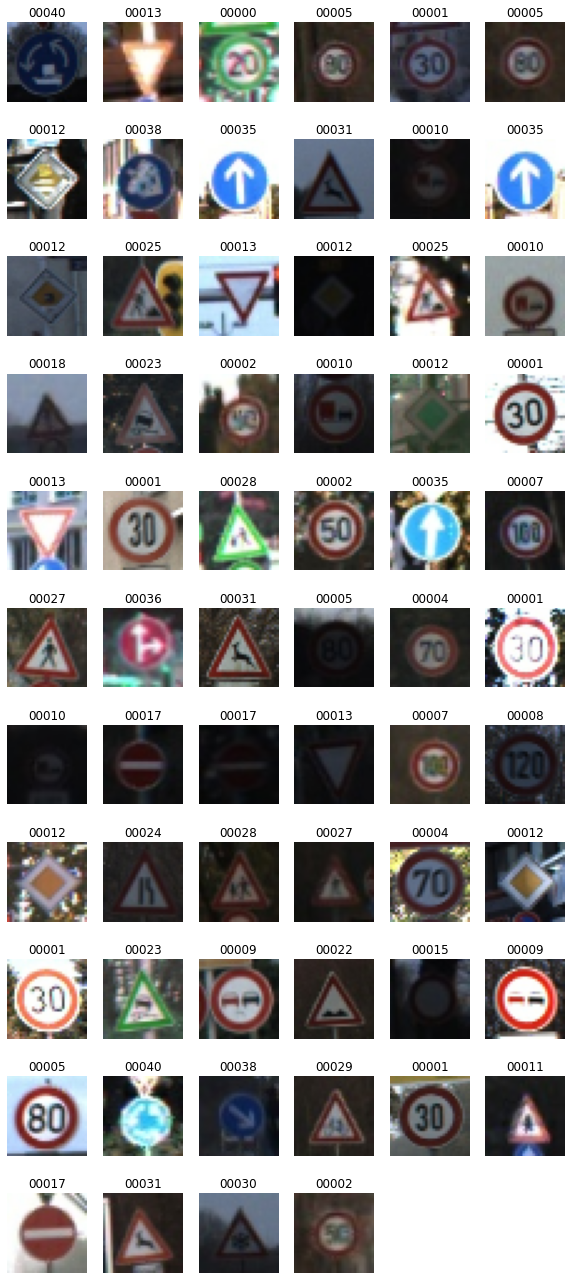

In [11]:
image_batch, label_batch = next(iter(data))
print(label_batch)
show_batch(image_batch, label_batch.numpy())

### Build a CNN network

In [12]:
def create_model(classCount, imgSize, channels):

    modelLogits = Sequential()
    
    modelLogits.add(Conv2D(128, (5, 5),
                input_shape=(imgSize, imgSize, channels)))         
    modelLogits.add(LeakyReLU(alpha=0.01))  
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Conv2D(196, (5, 5) )) 
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Conv2D(256, (5, 5) ) )   
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 
    
    modelLogits.add(Flatten())
    modelLogits.add(Dense(384))
    modelLogits.add(LeakyReLU(alpha=0.0))             
    modelLogits.add(Dropout(0.5)) 
    
    modelLogits.add(Dense(classCount))
    
    output = Activation('softmax')(modelLogits.output)

    model = tf.keras.Model(modelLogits.inputs, output)
    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model, modelLogits


In [13]:
NUM_MODELS = 1

In [14]:
def train_models(train, val,file_path_prefix):

    models = []
    histories = []
    
    for i in range(NUM_MODELS):

        model, modelL = create_model(NUM_CLASSES,IMAGE_SIZE,3)

        callbacks = prepare_callbacks(f'{file_path_prefix}_{i:02}/cp.ckpt')

        hist = model.fit(train,
                              steps_per_epoch = 39209/BATCH_SIZE,
                              epochs=100, 
                              validation_data = val, 
                              callbacks = callbacks)

        models.append([model, modelL])
        histories.append(hist)
    
    return models,histories
 
def create_models():

    models = []
    
    for i in range(NUM_MODELS):
        model, modelL = create_model(NUM_CLASSES,IMAGE_SIZE,3)
        models.append([model, modelL])

    return models

file_path_prefix = './model_V1/cp.ckpt'

models_V1, histories_V1 = train_models(data, valset, file_path_prefix)
#models_V1 = create_models()

Epoch 1/100
613/612 [==============================] - ETA: 0s - loss: 3.4967 - accuracy: 0.2666

ResourceExhaustedError:  OOM when allocating tensor with shape[2580,196,24,24] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_1/Conv2D (defined at <ipython-input-14-577e48ca265e>:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_3291]

Function call stack:
test_function


In [22]:
def load_weights(models, file_path_prefix):
    for i in range(NUM_MODELS):
        file_path = f'{file_path_prefix}_{i:02}/cp.ckpt'
        models[i][0].load_weights(file_path)
        models[i][0].save('temp.hdf5')
        models[i][1].load_weights('temp.hdf5', by_name = True)
        
load_weights(models_V1, file_path_prefix)

In [24]:
def evaluate_models(models):
    
    accuracy = 0
    
    for i in range(NUM_MODELS):
        eval = models[i][0].evaluate(testset, verbose = 2)
        accuracy += eval[1]
        
    print(f'average accuracy: {(accuracy/NUM_MODELS)*100:.3f}')
    
evaluate_models(models_V1)

66/66 - 19s - loss: 0.0874 - accuracy: 0.9772
66/66 - 23s - loss: 0.0760 - accuracy: 0.9830
66/66 - 23s - loss: 0.0832 - accuracy: 0.9832
66/66 - 23s - loss: 0.0709 - accuracy: 0.9863
66/66 - 24s - loss: 0.0831 - accuracy: 0.9779
66/66 - 23s - loss: 0.0770 - accuracy: 0.9825
66/66 - 23s - loss: 0.0874 - accuracy: 0.9770
66/66 - 24s - loss: 0.0704 - accuracy: 0.9842
66/66 - 24s - loss: 0.0812 - accuracy: 0.9818
average accuracy: 98.145


In [28]:
def get_labels_logits_preds(models):
    
    preds = [[] for _ in range(NUM_MODELS)]
    logits = [[] for _ in range(NUM_MODELS)]
    labels = []
    
    for images, labs in testset.take(-1):
        labels.extend(labs.numpy())
        for i in range(NUM_MODELS):
            preds[i].extend(models[i][0].predict(images))
            logits[i].extend(models[i][1].predict(images))
            
    labels = [np.argmax(i) for i in labels]
    
    return labels, logits, preds

labels_V1, logits_V1, preds_V1 = get_labels_logits_preds(models_V1)

In [29]:
len(preds_V1)

9

In [32]:
def get_class_preds(preds):
    class_preds = []
    for i in range(test_dataset_length):
        c = []
        for m in range(NUM_MODELS):
            c.append(np.argmax(preds[m][i]))
            
        class_preds.append(c)
    
    return class_preds

class_preds_V1 = get_class_preds(preds_V1)

In [34]:
class_preds_V1[:10]

[[6, 6, 6, 6, 6, 6, 6, 6, 6],
 [6, 6, 6, 6, 6, 6, 6, 6, 6],
 [4, 4, 4, 4, 4, 4, 4, 4, 4],
 [1, 2, 2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4, 4, 4, 4, 4],
 [6, 6, 6, 6, 6, 6, 6, 6, 6],
 [2, 2, 2, 2, 2, 2, 2, 2, 2],
 [4, 4, 4, 4, 4, 4, 4, 4, 4]]

In [37]:
labels_V1[:10]

[6, 6, 4, 2, 2, 4, 4, 6, 2, 4]

In [36]:
def get_class_from_sum_of_logits(logits):
    sum_logits = []
    
    for i in range(test_dataset_length):
        log = logits[0][i]
        for m in range(1, NUM_MODELS):
            log = np.add(log ,logits[m][i])
            
        sum_logits.append(np.argmax(log))
    return sum_logits

class_logits_V1 = get_class_from_sum_of_logits(logits_V1)

In [41]:
class_preds_V1[0], collections.Counter(class_preds_V1[0])

([6, 6, 6, 6, 6, 6, 6, 6, 6], Counter({6: 9}))

In [52]:
def get_stats(labels, class_preds, class_logits):
    
    all_correct = 0
    all_incorrect = 0
    
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    
    log_ok = 0
    log_ko = 0
    
    count = 0
    
    for i in range(test_dataset_length):
        
        counter = collections.Counter(class_preds[i])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[i]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[i]:
                maj_vote += 1
            elif aux[0][1] > aux[1][1] and aux[0][0] != labels[i]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1
                
        if class_logits[i] == labels[i]:
            log_ok += 1
        else:
            log_ko += 1
        
        count +=1

    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko]
                                     
res = get_stats(labels_V1, class_preds_V1, class_logits_V1)

In [53]:
res, res[6]/res[0]

([4170, 4008, 22, 94, 3, 43, 4108, 62], 0.9851318944844125)

In [55]:
test_logits_preds = []

for i in range(test_dataset_length):
    
    aux = []
    for n in range(NUM_MODELS):
        aux.extend(logits_V1[n][i])
    
    test_logits_preds.append(aux)
        
    

In [58]:
logits_train = [[] for _ in range(NUM_MODELS)]
labels_aux = []

for images, labs in dataSolo.take(-1):
    
    labels_aux.extend(labs.numpy())
    for i in range(NUM_MODELS):
        logits_train[i].extend(models_V1[i][1].predict(images))
        
labels_train = [np.argmax(i) for i in labels_aux]

In [ ]:
train_logits_preds = []

for i in range(dataset_length):
    aux = []
    for n in range(NUM_MODELS):
        aux.extend(logits_train[n][i])
    train_logits_preds.append(aux)
    
train_logits_preds

In [60]:
stack_model = tf.keras.models.Sequential([
    Flatten(input_shape = (72,)),
    Dense(32),
    LeakyReLU(alpha = 0.01),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(8, activation = 'softmax')
])

stack_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [61]:
stack_model.fit(np.asarray(train_logits_preds), np.asarray(labels_train), epochs = 20, batch_size = 32)

Epoch 1/20
319/319 [==============================] - 1s 2ms/step - loss: 0.9913 - accuracy: 0.7016
Epoch 2/20
319/319 [==============================] - 1s 2ms/step - loss: 0.1101 - accuracy: 0.9856
Epoch 3/20
319/319 [==============================] - 1s 2ms/step - loss: 0.0587 - accuracy: 0.9929
Epoch 4/20
319/319 [==============================] - 1s 2ms/step - loss: 0.0368 - accuracy: 0.9962
Epoch 5/20
319/319 [==============================] - 1s 2ms/step - loss: 0.0237 - accuracy: 0.9974
Epoch 6/20
319/319 [==============================] - 1s 2ms/step - loss: 0.0208 - accuracy: 0.9971
Epoch 7/20
319/319 [==============================] - 1s 2ms/step - loss: 0.0181 - accuracy: 0.9974
Epoch 8/20
319/319 [==============================] - 1s 2ms/step - loss: 0.0173 - accuracy: 0.9968
Epoch 9/20
319/319 [==============================] - 1s 2ms/step - loss: 0.0128 - accuracy: 0.9980
Epoch 10/20
319/319 [==============================] - 1s 2ms/step - loss: 0.0106 - accuracy: 0.9978

In [62]:
pred = stack_model.predict(np.asarray(test_logits_preds))

In [65]:
correct = 0

for i in range(test_dataset_length):
    if np.argmax(pred[i]) == labels_V1[i]:
        correct += 1
        
correct, correct/test_dataset_length * 100

(4072, 97.64988009592327)